In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('../../data/data_cleaned.csv')

In [3]:
X = df.drop(columns='non_functional')
y = df['non_functional']

In [4]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

In [5]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 22), (40070,), (13357, 22), (13357,), (5937, 22), (5937,))

In [10]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5, grid_search=False):
    '''
    
    '''
    if grid_search == False:
        # Cross-Validate
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])

        print('Results of Cross-Validation:\n')
        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'**Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}\n')
        print('+'*20)
    
        # Test Validate
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)

        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')

        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')

        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")

        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)

        categories = ['Functional', 'Non-Functional']
        print('\nResults of Train-Test Split Validation:')

        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                              cmap='mako')

        print("\nTraining Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")

        print("<>"*10)
        print("\nTesting Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"**Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



In [11]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

## Stupid Dummy Idiot Model

In [ ]:
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, max_iter=1000))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

evaluate(dt, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=5))
])
evaluate(rf, X_train, X_test, y_train, y_test, cross_val=False, cv=5)

## Slightly less dummy models

In [ ]:
logreg2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, penalty='l1', solver = 'liblinear', max_iter=1000))
])

evaluate(logreg2, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
logreg3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, solver = 'liblinear', max_iter=1000))
])

evaluate(logreg3, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
logreg3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, solver = 'newton-cg', max_iter=1000))
])

evaluate(logreg3, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
logreg4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, max_iter=500))
])

evaluate(logreg4, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
# test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        print('Best Params: {}'.format(gs_pipe.best_params_))
        print('Best Score: {}'.format(gs_pipe.best_score_))

        scores = gs_pipe.cv_results_
    return scores

In [ ]:
dt_test_list = [{'name':'dt', 'type':DecisionTreeClassifier(), 'params':{'dt__random_state': [396],
                                                                      'dt__criterion': ['gini', 'entropy'],
                                                                     'dt__max_features': [None, 'sqrt', 'log2'],
                                                                     'dt__max_depth':[20,40,80]}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
dt_tests = model_tests(X_train_processed, y_train, test_list)

In [ ]:
dt2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=20))
])

evaluate(dt2, X_train, X_test, y_train, y_test, cross_val=True, cv=5)

In [ ]:
dt2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=20))
])

evaluate(dt2, X_train, X_test, y_train, y_test, cross_val=False, cv=5)

In [ ]:
dt3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=10))
])

evaluate(dt3, X_train, X_test, y_train, y_test, cross_val=False, cv=5)

In [ ]:
dt4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396, criterion='gini', max_depth=30))
])

evaluate(dt4, X_train, X_test, y_train, y_test, cross_val=False, cv=5)

In [ ]:

dt_tests_df = pd.DataFrame(dt_tests)

In [ ]:
dt_tests_df.head()

In [15]:
rf_test_list = {
    'rf__n_estimators': [10, 50, 100],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth':[None, 5, 20],
    'rf__class_weight' : [None, 'balanced']}
#fit_intercept=False, C= 1e12, solver='liblinear'

In [14]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

In [16]:
cv = GridSearchCV(pipeline, param_grid=rf_test_list)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('ii',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           random_state=396)),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['id',
                                                                          'amount_tsh',
                                                                          'gps_height',
                                                 

In [19]:
print('Best Params: {}'.format(cv.best_params_))
print('Best Score: {}'.format(cv.best_score_))

cv_scores = cv.cv_results_
 

Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__n_estimators': 100}
Best Score: 0.8163963064636885


In [20]:
rf_test2_list = {
    'rf__n_estimators': [125,150],
    'rf__criterion': ['entropy'],
    'rf__max_depth':[25,50],
    'rf__class_weight' : ['balanced']}

In [21]:
cv2 = GridSearchCV(pipeline, param_grid=rf_test2_list)
cv2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('ii',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           random_state=396)),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['id',
                                                                          'amount_tsh',
                                                                          'gps_height',
                                                 

In [22]:
print('Best Params: {}'.format(cv2.best_params_))
print('Best Score: {}'.format(cv2.best_score_))

cv2_scores = cv2.cv_results_
 

Best Params: {'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 25, 'rf__n_estimators': 150}
Best Score: 0.816446219116546


In [26]:
estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=5, n_estimators=200))
])

Results of Cross-Validation:

Average accuracy: 0.7397554280009982        +/- 0.004678629016073833
Average precision: 0.7768073608049973        +/- 0.006354756504311561
**Average recall: 0.6040625865712826        +/- 0.017548096259159814
Average f1 score: 0.6794353194284297        +/- 0.00982181205170732
Average roc_auc: 0.8106804321039913        +/- 0.004068094271709051

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7408035937110058
Train precision: 0.7853025936599424
**Train recall: 0.5954331913033978
Train f1 score: 0.6773131175045051
Train roc_auc: 0.7292549158134339

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7364677697087669
Test precision: 0.7808928186327366
**Test recall: 0.5911836734693877
Test f1 score: 0.6729232484668277
Test roc_auc: 0.7253484739028355


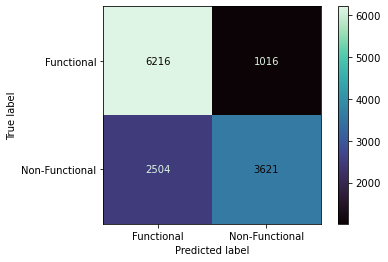

In [27]:
evaluate(estimator, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [28]:
estimator2 = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=10, n_estimators=150))
])

Results of Cross-Validation:

Average accuracy: 0.778163214374844        +/- 0.0021762145601788648
Average precision: 0.8124912456861815        +/- 0.005650520513596466
**Average recall: 0.6689054674785861        +/- 0.010569685758163045
Average f1 score: 0.7336533496799695        +/- 0.004668091891683296
Average roc_auc: 0.8594066784519574        +/- 0.0027919063282110666

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.7967307212378338
Train precision: 0.8392201375442345
**Train recall: 0.6866054845405878
Train f1 score: 0.7552804735150076
Train roc_auc: 0.7879820291660851

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7771954780265029
Test precision: 0.8120911793855302
**Test recall: 0.6688979591836735
Test f1 score: 0.7335720680393911
Test roc_auc: 0.7689069441936066


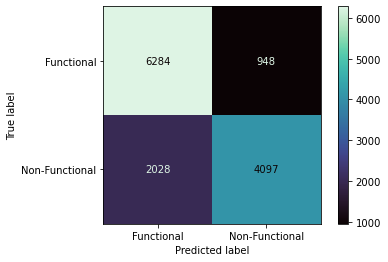

In [29]:
evaluate(estimator2, X_train, X_test, y_train, y_test, cv=5, grid_search=False)

In [ ]:
def evaluate2(estimator, X_tr, X_te, y_tr, y_te, cross_val=True, cv=5):
    '''
    
    '''
    if cross_val == True:
        output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                                scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])

        print(f'Average accuracy: {output["test_accuracy"].mean()}\
        +/- {output["test_accuracy"].std()}')
        print(f'Average precision: {output["test_precision"].mean()}\
        +/- {output["test_precision"].std()}')
        print(f'Average recall: {output["test_recall"].mean()}\
        +/- {output["test_recall"].std()}')
        print(f'Average f1 score: {output["test_f1"].mean()}\
        +/- {output["test_f1"].std()}')
        print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
        +/- {output["test_roc_auc"].std()}')
    
    else:
        estimator.fit(X_tr, y_tr)
        tr_preds = estimator.predict(X_tr)
        te_preds = estimator.predict(X_te)
    
        categories = ['Functional', 'Non-Functional']
        plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories)
    
        print("Training Scores:")
        print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
        print(f"Train precision: {precision_score(y_tr, tr_preds)}")
        print(f"Train recall: {recall_score(y_tr, tr_preds)}")
        print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
        print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}")

        print("<>"*10)
        print("Testing Scores:")
        print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
        print(f"Test precision: {precision_score(y_te, te_preds)}")
        print(f"Test recall: {recall_score(y_te, te_preds)}")
        print(f"Test f1 score: {f1_score(y_te, te_preds)}")
        print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")